<a href="https://colab.research.google.com/github/SYKIM5396/Airline_Satisfaction/blob/main/Part4_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders
!pip install --upgrade lightgbm
!pip install eli5
!pip install pdpbox
!pip install hyperopt

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

%matplotlib inline
plt.rcParams["figure.dpi"] = 144

import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from lightgbm import LGBMClassifier
from hyperopt import hp
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, Trials, STATUS_OK
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

import warnings
warnings.filterwarnings("ignore")

# 4. 최종 모델 최적화 및 일반화 성능 평가

In [2]:
#데이터셋 불러오기
train = pd.read_csv('https://raw.githubusercontent.com/SYKIM5396/Airline_Satisfaction/main/train_processed.csv')
test = pd.read_csv('https://raw.githubusercontent.com/SYKIM5396/Airline_Satisfaction/main/test_processed.csv')

In [3]:
target = 'satisfaction'
X_train, y_train = train.drop(columns=target), train[target]
X_test, y_test = test.drop(columns=target), test[target]

In [4]:
#ordinal encoder 맵핑
mapping = [{'col': 'Gender', 'mapping': {'Female' : 1,  'Male' : 2,  None :-2}},
 {'col': 'Customer_Type', 'mapping': {'disloyal Customer' :1, 'Loyal Customer' : 2,  None :-2}},
 {'col': 'Type_of_Travel', 'mapping': {'Personal Travel' :   1 ,  'Business travel' :  2, None :-2}},
 {'col': 'Class', 'mapping': {'Eco':1, 'Eco Plus' : 2 ,'Business':3,  None :-2}}
]

## 최종 모델 하이퍼 파라미터 튜닝

In [5]:
# train set 전체에 대한 모델의 CV 검증 성능 재확인
# 랜덤서치로 찾은 파라미터 3개를 넣어줬다.
pipe_lgbm = make_pipeline(
        OrdinalEncoder(mapping=mapping),
        LGBMClassifier(random_state=53,
                       n_estimators=200,
                       min_child_weight=4,
                       max_depth=11,
                       learning_rate=0.1,                              
                               n_jobs=-1)
        )
lgbm_cv_score = cross_val_score(pipe_lgbm,X_train, y_train,scoring='f1',cv=5)
print(f" cross val f1 is {lgbm_cv_score.mean()}")

 cross val f1 is 0.9581350043786913


In [11]:
#하이퍼 파라미터 서치 범위 지정
params = {
    "lgbmclassifier__max_depth": hp.quniform("max_depth", 5,15,1),
    "lgbmclassifier__colsample_bytree" : hp.uniform("colsample_bytree", 0.8, 1.0),
    "lgbmclassifier__subsample": hp.uniform("subsample", 0.6, 1.0),
    "lgbmclassifier__min_child_weight": hp.quniform("min_child_weight", 4, 20, 4),
    "lgbmclassifier__n_estimators": hp.quniform("n_estimators", 100,2000,50),
    "lgbmclassifier__learning_rate": hp.quniform("learning_rate", 0.06, 0.2, 0.02)
}

In [12]:
def get_pipe(params):
    params["lgbmclassifier__n_estimators"] = int(
        params["lgbmclassifier__n_estimators"])
    params["lgbmclassifier__max_depth"] = int(
        params["lgbmclassifier__max_depth"])
    
    pipe = make_pipeline(
        OrdinalEncoder(mapping=mapping),
        LGBMClassifier(random_state=53,                              
                               n_jobs=-1)
        )
    pipe = pipe.set_params(**params)
    return pipe

def fit_and_eval(params):
    pipe = get_pipe(params)  
    score = cross_val_score(pipe, X_train, y_train, cv=5, scoring="f1")
    avg_cv_score = np.mean(score)
    return {"loss": -avg_cv_score, "status": STATUS_OK}

trials = (Trials())

best_params = fmin(
    fn=fit_and_eval, trials=trials, space=params, algo=tpe.suggest, max_evals=20
) 

100%|██████████| 20/20 [20:34<00:00, 61.73s/it, best loss: -0.9585680850389977]


In [13]:
print("최적 하이퍼파라미터: ", trials.best_trial["misc"]["vals"])
print("최적 AUC: ", -trials.best_trial["result"]["loss"])

최적 하이퍼파라미터:  {'colsample_bytree': [0.9693981253907349], 'learning_rate': [0.08], 'max_depth': [12.0], 'min_child_weight': [4.0], 'n_estimators': [350.0], 'subsample': [0.8218746296933642]}
최적 AUC:  0.9585680850389977


In [17]:
# 튜닝된 파라미터로 모델을 업데이트
pipe_lgbm = make_pipeline(
        OrdinalEncoder(mapping=mapping),
        LGBMClassifier(random_state=53,
                       colsample_bytree = 0.9693981253907349,
                       learning_rate = 0.08,
                       max_depth = 12,
                       min_child_weight = 4,
                       n_estimators=350,
                       subsample =0.8218746296933642,                             
                       n_jobs=-1)
        )
pipe_lgbm.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Gender', 'Customer_Type',
                                      'Type_of_Travel', 'Class'],
                                mapping=[{'col': 'Gender',
                                          'mapping': {None: -2, 'Female': 1,
                                                      'Male': 2}},
                                         {'col': 'Customer_Type',
                                          'mapping': {None: -2,
                                                      'Loyal Customer': 2,
                                                      'disloyal Customer': 1}},
                                         {'col': 'Type_of_Travel',
                                          'mapping': {None: -2,
                                                      'Business travel': 2,
                                                      'Personal Travel': 1}},
                                         {'col': 'Class',
   

## 최종모델 평가, 일반화 성능 검증

In [27]:
lgbm_cv_score = cross_val_score(pipe_lgbm,X_train, y_train,scoring='f1',cv=5)
print(f" cross val f1 is {lgbm_cv_score.mean()}")

 cross val f1 is 0.9585680850389977


In [28]:
y_pred = pipe_lgbm.predict(X_test)
y_pred_proba = pipe_lgbm.predict_proba(X_test)[:,1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("Evaluation Metrics of Test set")
print(f'accuracy : {accuracy.round(3)}')
print(f'precision : {precision.round(3)}')
print(f'recall : {recall.round(3)}')
print(f'f1 : {f1.round(3)}')
print(f"auc score : {auc.round(3)}")

Evaluation Metrics of Test set
accuracy : 0.965
precision : 0.974
recall : 0.945
f1 : 0.96
auc score : 0.995


# 5. 모델 해석

## Feature Importance(Mean decrease impurity)

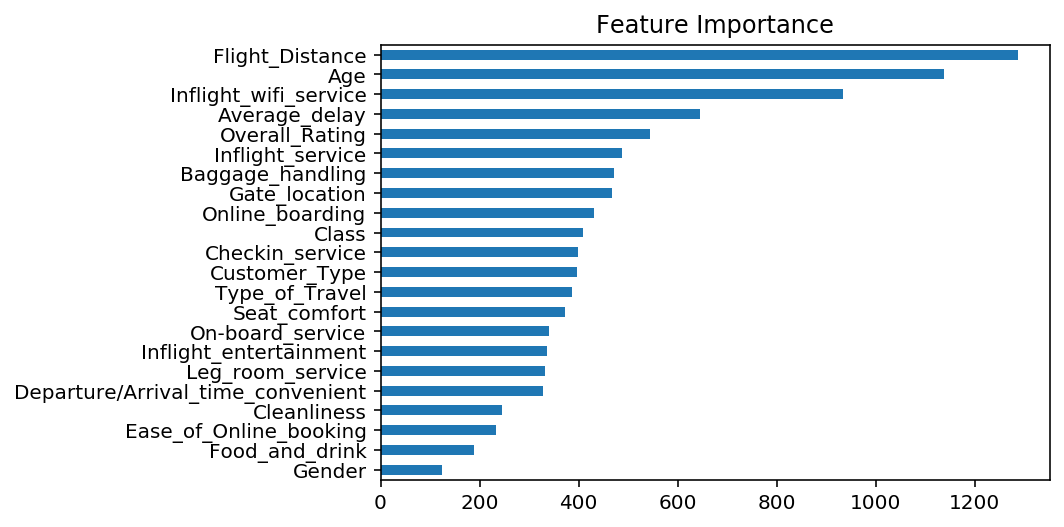

In [29]:
model = pipe_lgbm.named_steps["lgbmclassifier"]
importances = pd.Series(model.feature_importances_, X_train.columns)

importances.sort_values().plot.barh()
plt.title("Feature Importance")
plt.show()

불순도 기반의 특성 중요도는 수치형 변수나 카디널리티에 영향을 받기 쉬움으로 순열 중요도를 구해보자.

## Permutation Importance

In [50]:
permuter = PermutationImportance(
    pipe_lgbm.named_steps["lgbmclassifier"],
    scoring="f1",  
    n_iter=10,
    random_state=53,
)

In [51]:
X_test_preprocessed = pipe_lgbm[0].transform(X_test)
permuter.fit(X_test_preprocessed, y_test)

PermutationImportance(estimator=LGBMClassifier(colsample_bytree=0.9693981253907349,
                                               learning_rate=0.08, max_depth=12,
                                               min_child_weight=4,
                                               n_estimators=350,
                                               random_state=53,
                                               subsample=0.8218746296933642),
                      n_iter=10, random_state=53, scoring='f1')

In [52]:
feature_names = X_test.columns.tolist()
eli5.show_weights(
    permuter,
    top=None,  # top n 지정 가능, None 일 경우 모든 특성
    feature_names=feature_names,  # list 형식으로 넣어야 합니다
)

Weight,Feature
0.1839 ± 0.0054,Type_of_Travel
0.1650 ± 0.0036,Inflight_wifi_service
0.0884 ± 0.0015,Customer_Type
0.0315 ± 0.0020,Online_boarding
0.0306 ± 0.0012,Baggage_handling
0.0261 ± 0.0017,Inflight_service
0.0238 ± 0.0019,Checkin_service
0.0235 ± 0.0016,Seat_comfort
0.0180 ± 0.0012,Cleanliness
0.0094 ± 0.0009,Class


순열 중요도를 확인한 결과 Type_of_Travel, Inflight_wifi_service, Customer_Type, Online_boarding, Baggage_handling 순으로 중요도가 높은 것을 확인했다.

### 가설7 고객의 비행 만족도에 가장 많은 영향을 주는 요인은 무엇일까?

가설 : Seat comfort가 가장 많은 영향을 줄 것이다.

가설과는 달리, 순열중요도를 통해 비행 만족도에 가장 많은 영향을 주는 요인은 고객의 여행목적임을 알 수 있었다.  
Seat comfort는 순열중요도 8번째에 위치해 있었다.


## PDP

### Type_of_Travel

순열 중요도가 가장 높은 Type_of_Travel 특성에 대해 PDP plot을 그려보자

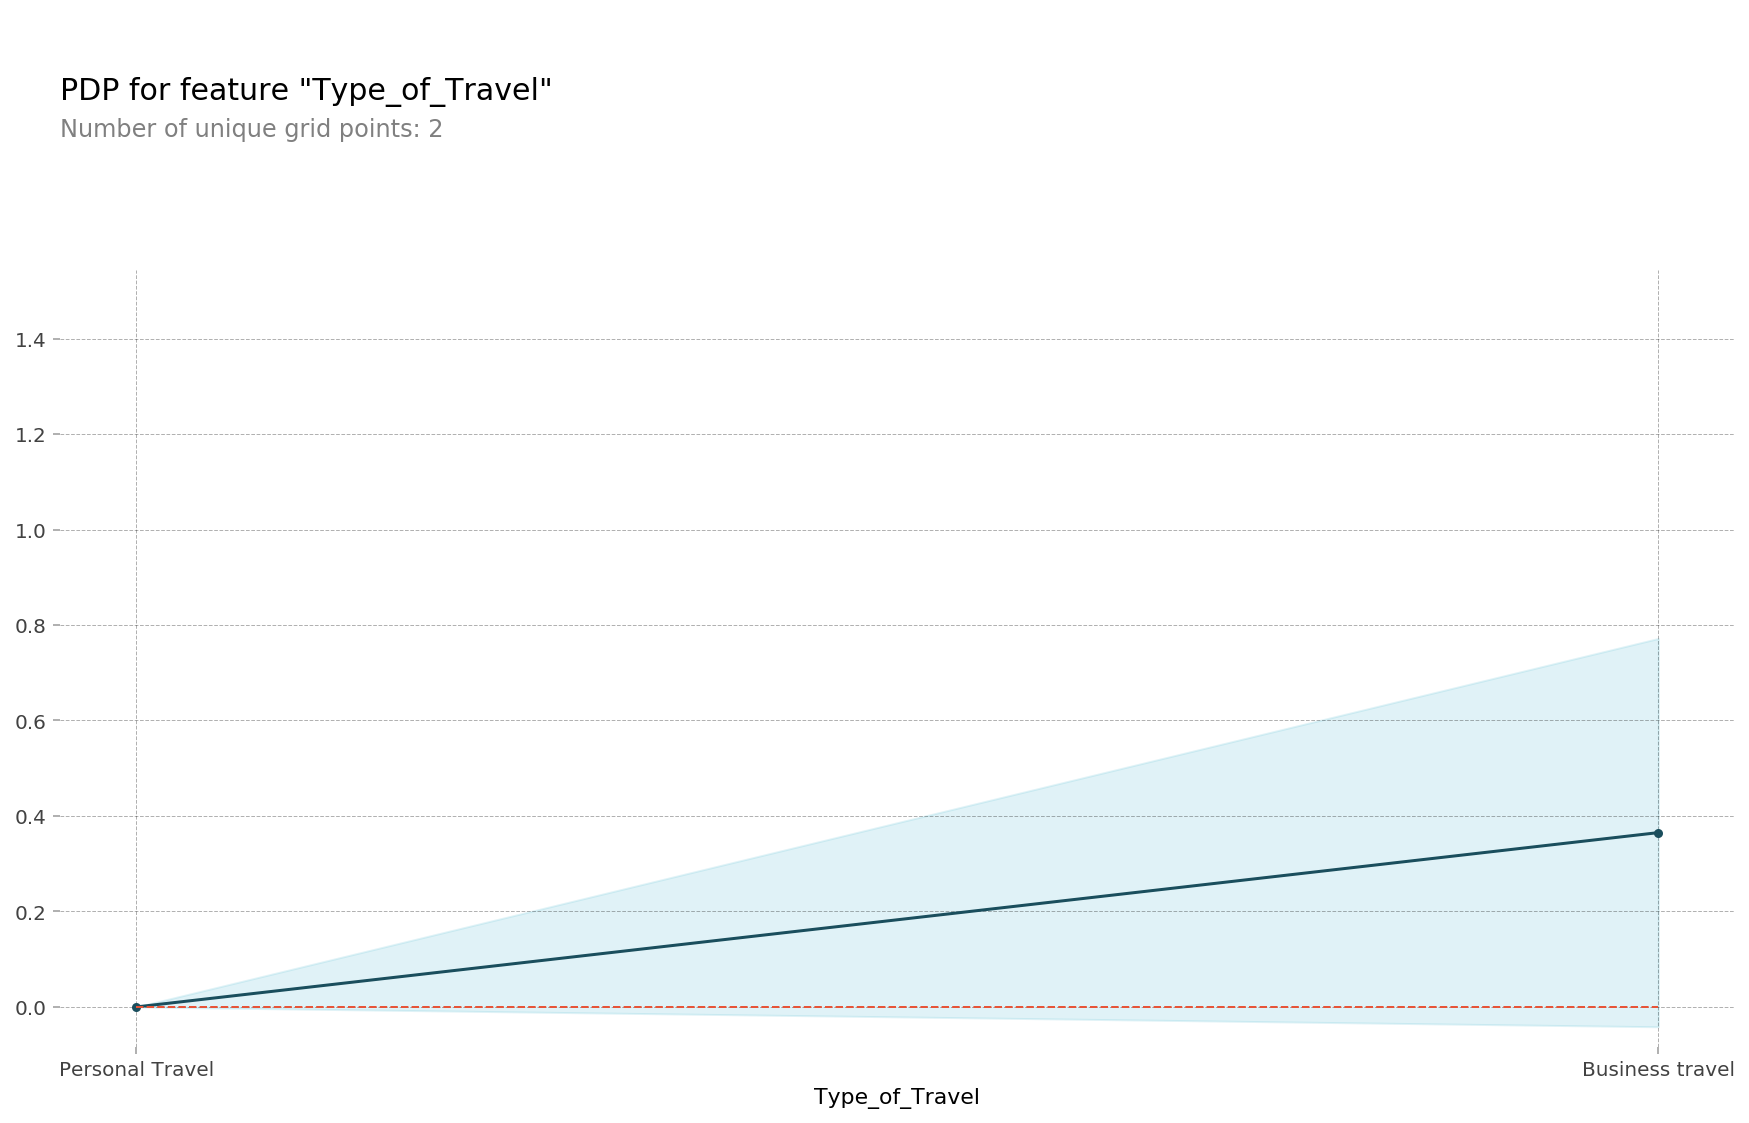

In [67]:
target_feature = 'Type_of_Travel'

X_train_preprocessed = pipe_lgbm[0].transform(X_train)

isolated = pdp_isolate(
    model=model,
    dataset=X_train_preprocessed,
    model_features=X_train_preprocessed.columns,
    feature=target_feature,
    grid_type="percentile", 
    num_grid_points=2,  
)
pdp_plot(isolated, feature_name=target_feature)
plt.xticks([1,2], ['Personal Travel', 'Business travel'])
plt.show()


PDP plot을 통해 business travel인 고객들이 personal 고객들에 비해 상대적으로 더 만족함을 알 수 있다.

### Average_delay

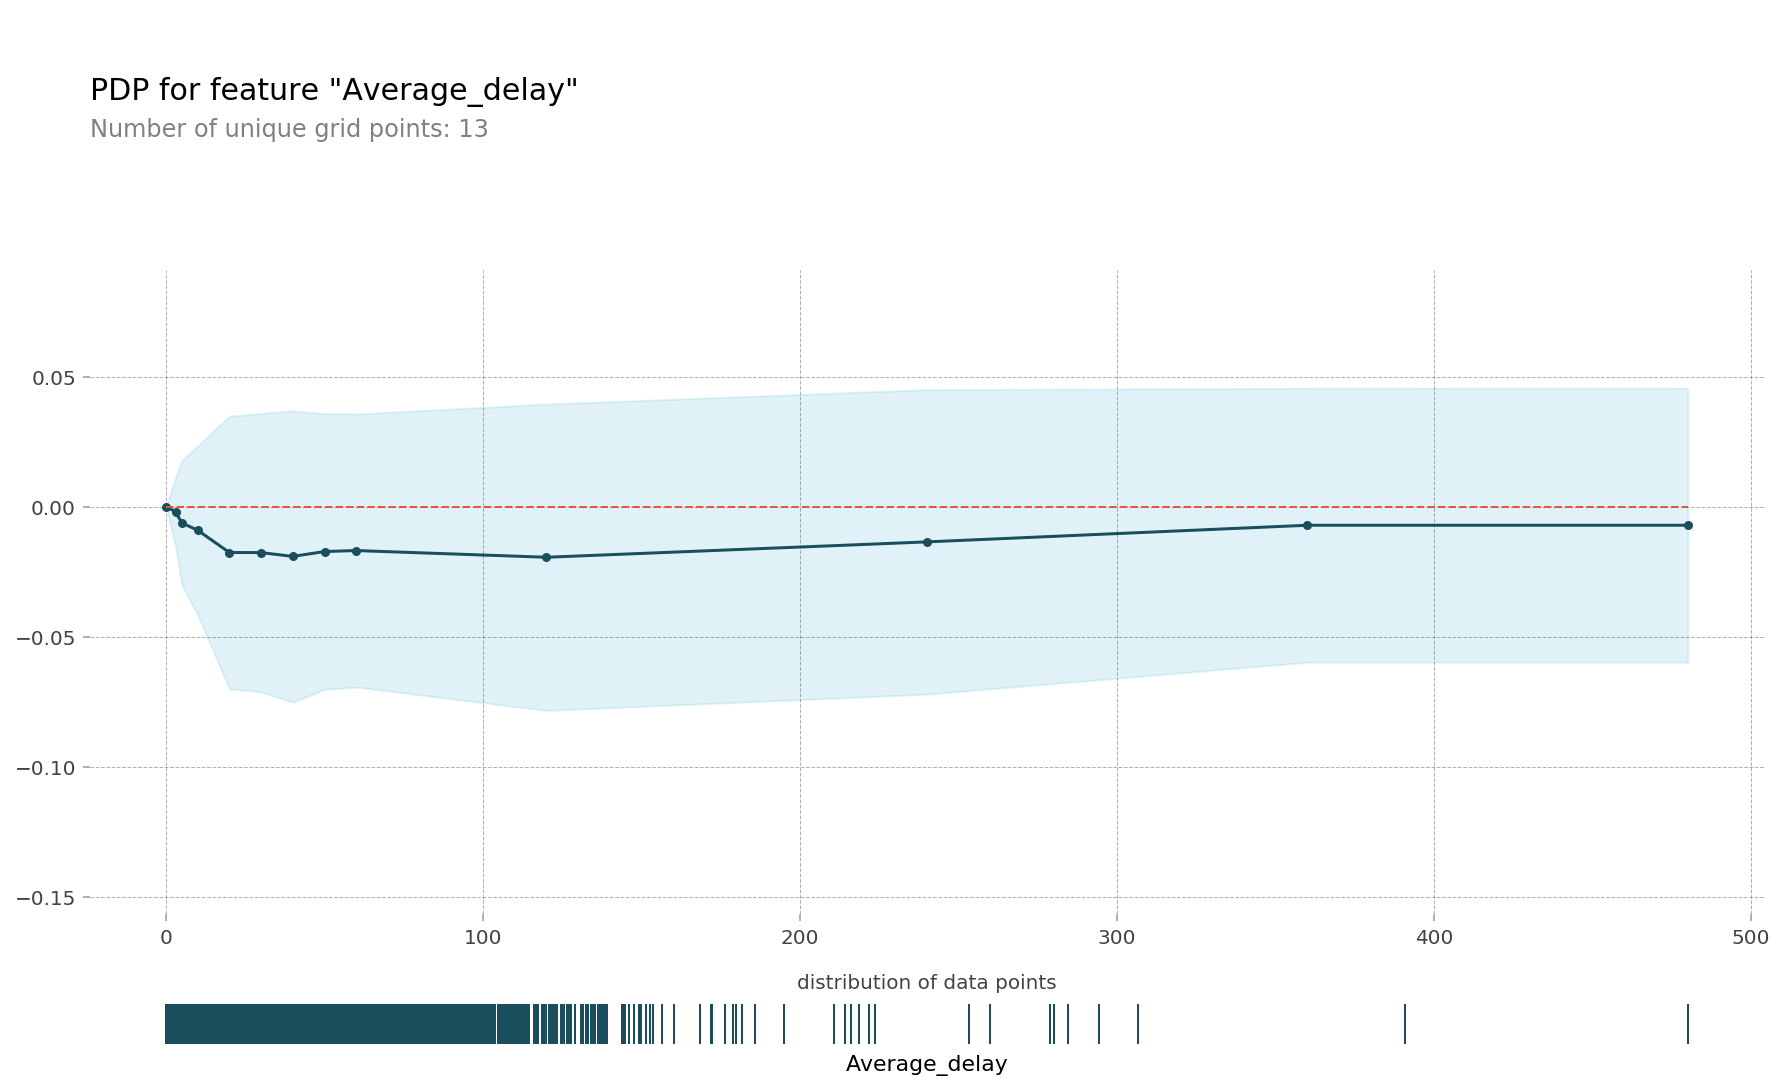

In [102]:
target_feature = 'Average_delay'

X_train_preprocessed = pipe_lgbm[0].transform(X_train)

isolated = pdp_isolate(
    model=model,
    dataset=X_train_preprocessed,
    model_features=X_train_preprocessed.columns,
    feature=target_feature,
    grid_type="percentile", 
    cust_grid_points= [0,3,5,10,20,30,40,50,60,120,240,360,480]
   )
pdp_plot(isolated, feature_name=target_feature,plot_pts_dist=True)
plt.show()

### 가설4 지연시간이 30분 이내라면 고객이 납득 할 수 있을것이다.

평균 지연시간이 3분이 넘어가면서 타겟 확률이 이미 하락하는 경향세를 보입니다.
고객의 만족도에 영향을 주는 최소 지연시간은 2~3분 정도입니다.
  
그리고 20분이 되면 하락세가 거의 최저지점에 도달하는데, 지연시간으로 인해 불만족을 느낄 승객들은 이미 불만족으로 다 돌아선 지점이라고 볼수 있습니다.  

특이하게도 지연시간이 길어질수록 만족도가 다시 회복되는 추세를 보이는데요, 아무래도 항공사 측에서 어떠한 보상을 제공해줬기 때문이 아닌가 추측됩니다.

### Type_of_Travel & Average_delay

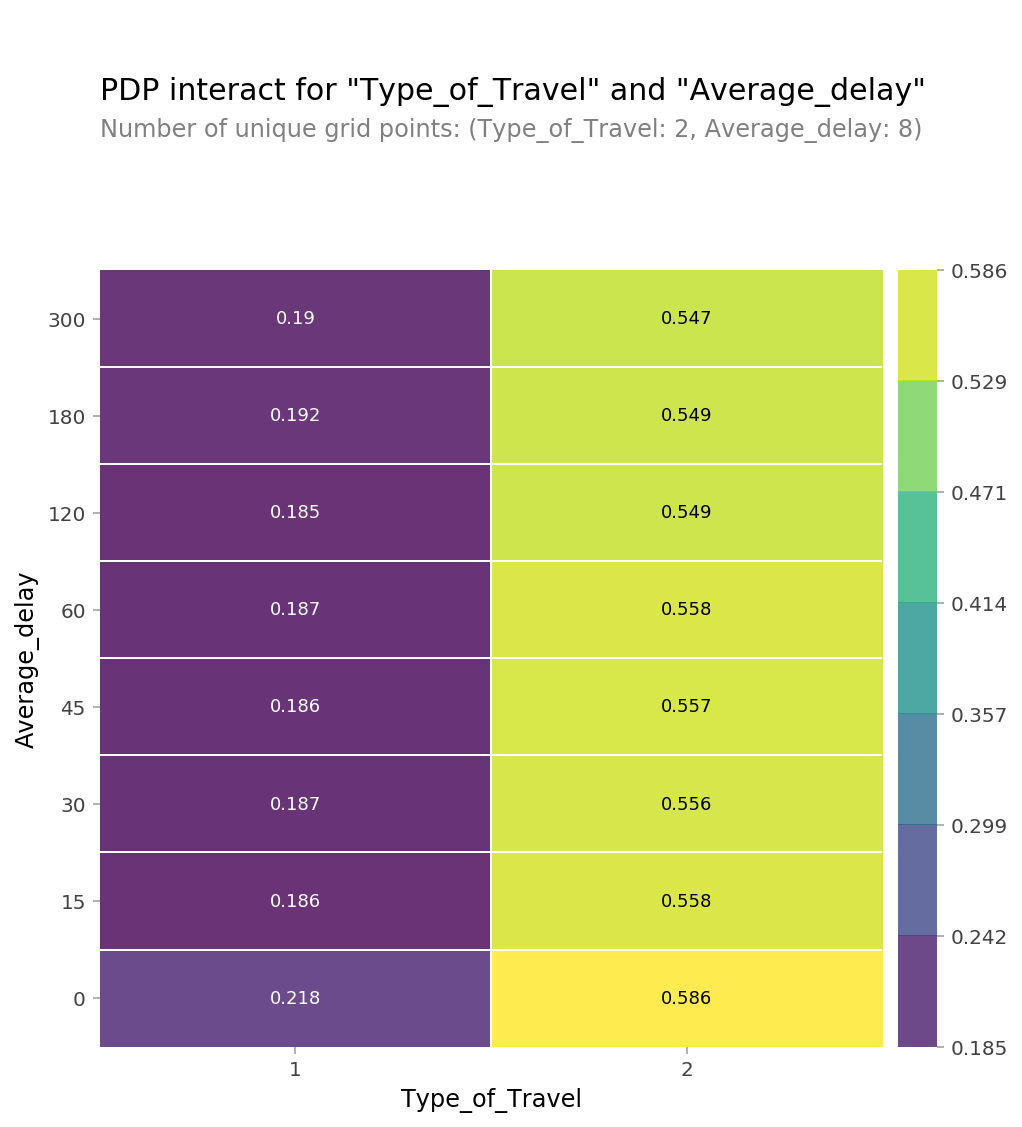

In [86]:
target_features = ["Type_of_Travel", "Average_delay"]

interaction = pdp_interact(
    model=model,
    dataset=X_train_preprocessed,
    model_features=X_train_preprocessed.columns,
    features=target_features,
    cust_grid_points=[[1,2],[0,15,30,45,60,120,180,300]]
    )
axes = pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)
plt.show()

### 가설6 비즈니스 목적의 승객의 경우, 지연시간에 더 민감하게 반응할 것이다.



개인 여행 승객은 지연시간이 15분~5시간 일때 0.19 정도로 대체로 비슷한확률 을 보이는 반면,  
비즈니스 목적 승객은 지연시간이 2시간이 되는 순간부터 확률이 0.01정도 더 떨어진것을 확인 할 수 있다.  
확연한 차이를 보이는것은 아니지만 비즈니스 목적 승객의 경우 개인 여행 승객보다 지연시간에 더 민감하게 반응하는 경향이 있다고 할 수 있다.

### age & various features

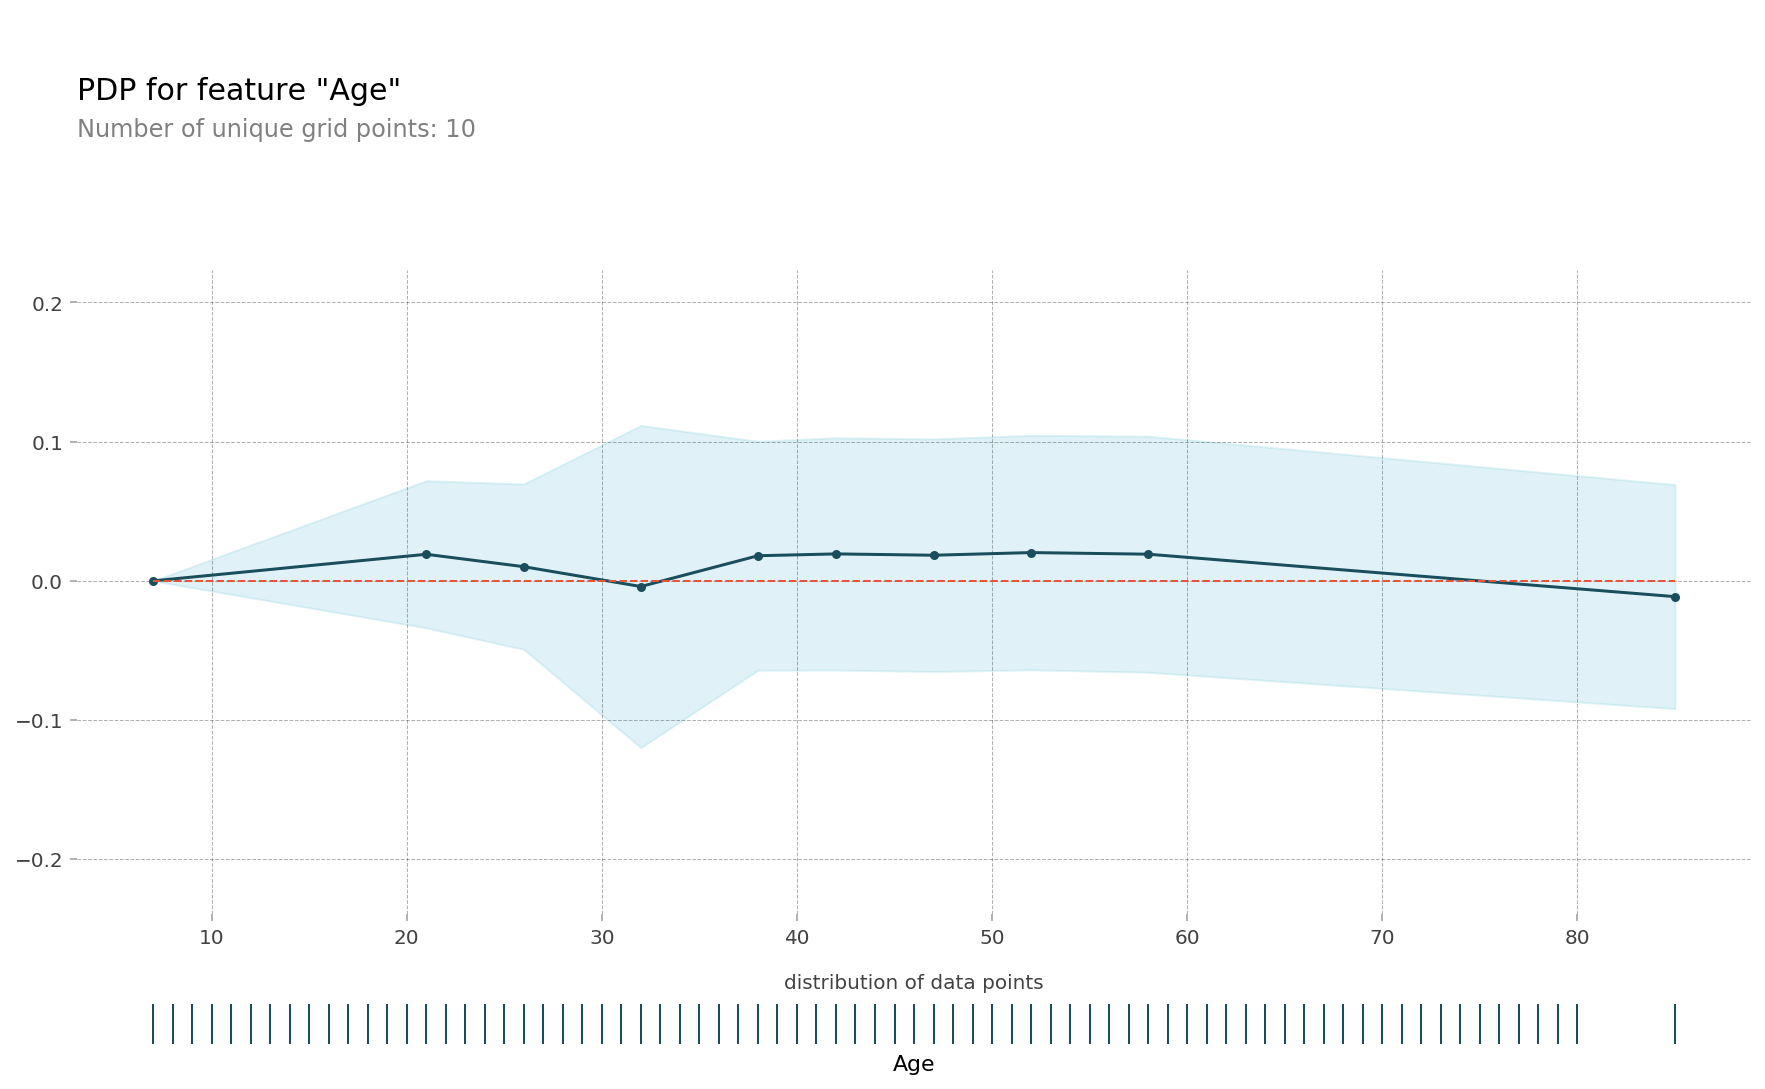

In [112]:
target_feature = 'Age'

X_train_preprocessed = pipe_lgbm[0].transform(X_train)

isolated = pdp_isolate(
    model=model,
    dataset=X_train_preprocessed,
    model_features=X_train_preprocessed.columns,
    feature=target_feature,
    grid_type="percentile", 
   )
pdp_plot(isolated, feature_name=target_feature,plot_pts_dist=True)
plt.show()

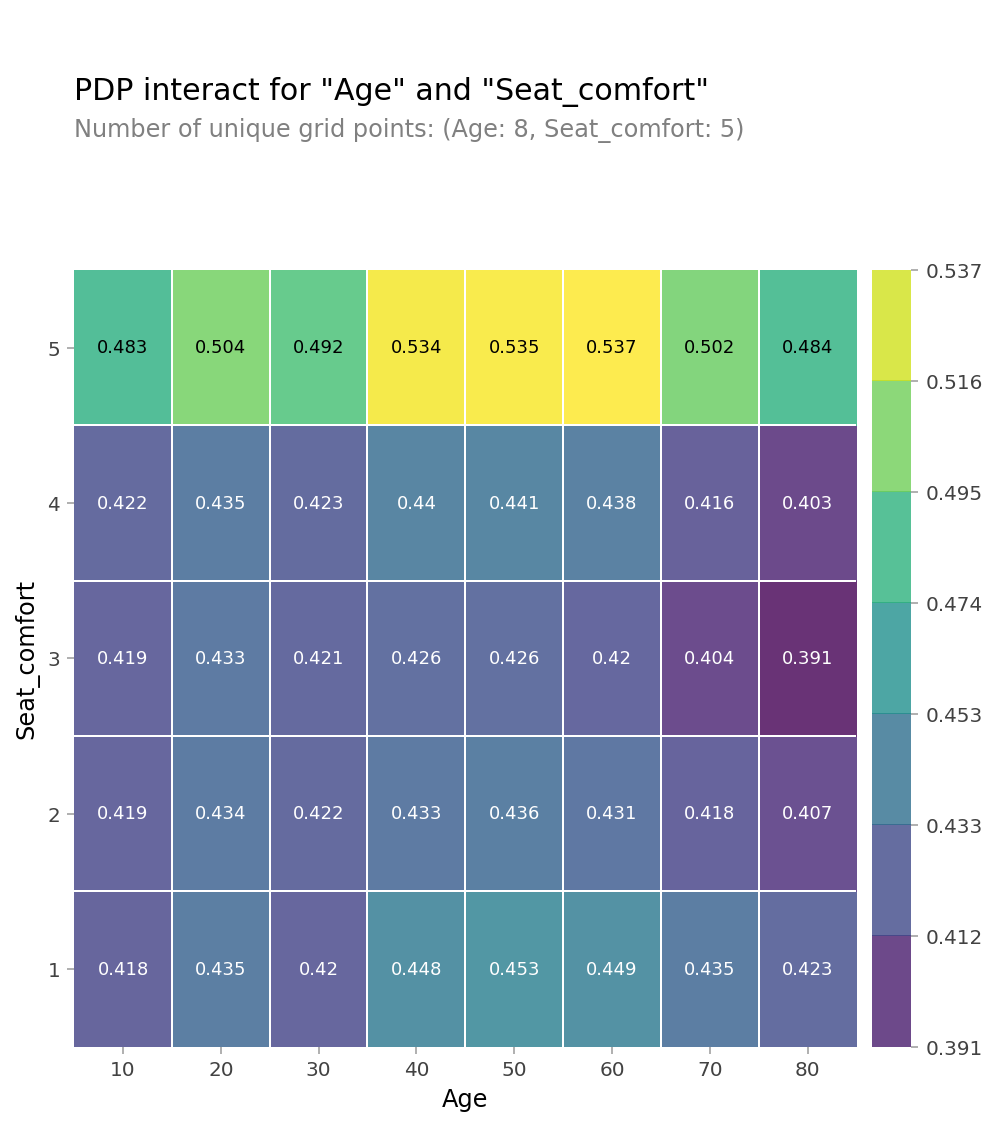

In [111]:
target_features = ["Age", 'Seat_comfort']

interaction = pdp_interact(
    model=model,
    dataset=X_train_preprocessed,
    model_features=X_train_preprocessed.columns,
    features=target_features,
    cust_grid_points=[[10,20,30,40,50,60,70,80],[1,2,3,4,5]]
    )
axes = pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)
plt.show()

Age특성과 다른 모든 특성에 대해 2특성 PDP를 그려본 결과 특이한 분포를 가진 히트맵이 2가지 있었습니다.  
우선은 좌석 편안도와 관련된 PDP 그래프입니다.    
40대 이상의 경우 좌석의 편안함이 만족도에 영향을 주는 정도가 다른 연령대 보다 높게 나타났습니다.  
40대이상의 고객의 경우 승무원이 잘 살피고 좌석 이용에 불편함이 없도록 관리할 필요가 있습니다. 필요한경우 쿠션이나 목베개를 제공하는 서비스도 

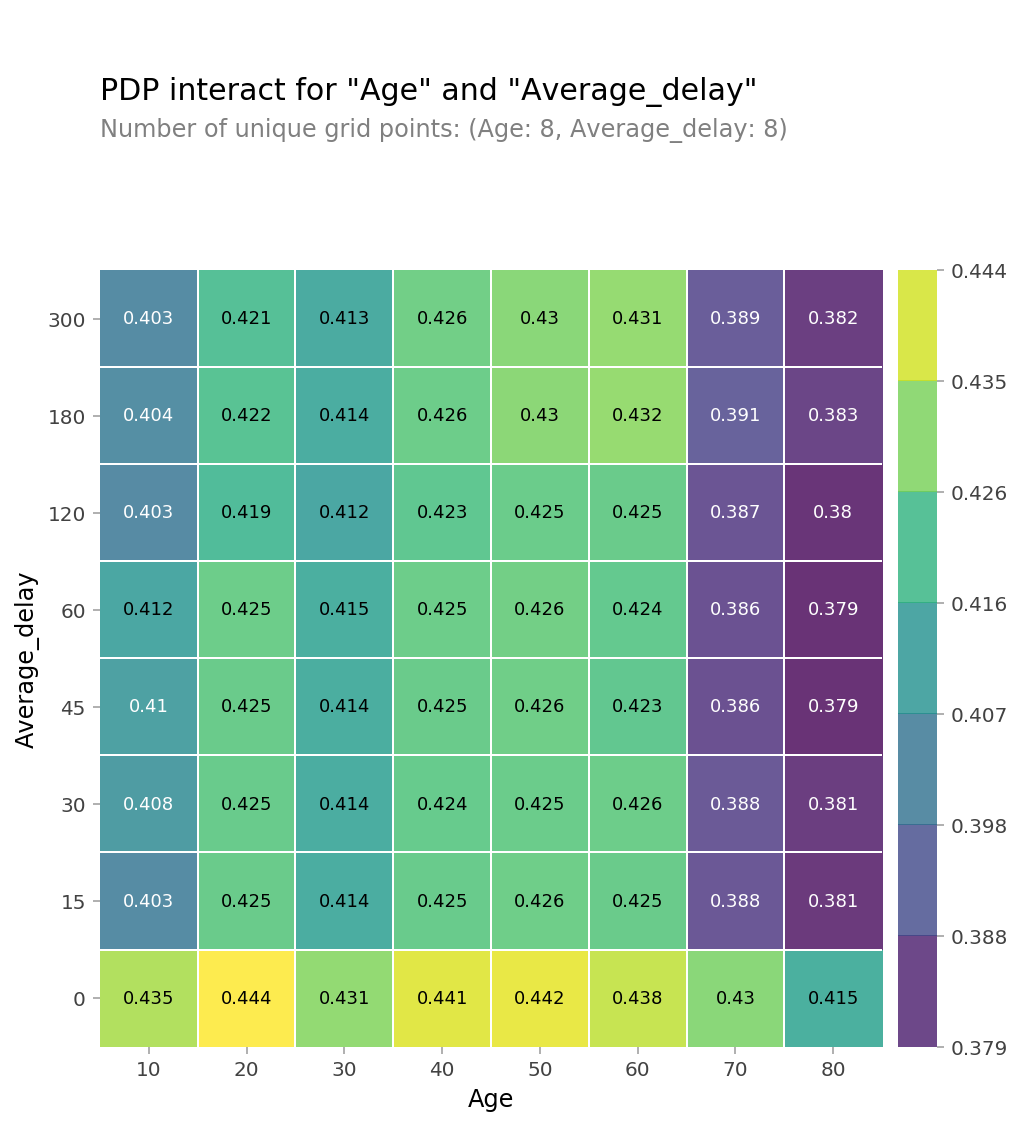

In [122]:
target_features = ["Age", 'Average_delay']

interaction = pdp_interact(
    model=model,
    dataset=X_train_preprocessed,
    model_features=X_train_preprocessed.columns,
    features=target_features,
    cust_grid_points=[[10,20,30,40,50,60,70,80],[0,15,30,45,60,120,180,300]]
    )
axes = pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)
plt.show()

다음으로 평균 지연시간과 AGE의 2특성 PDP plot입니다.  
70대이상의 고령층에게는 지연시간이 만족도에 주는 영향이 다른 연령대보다 더 크게 나타나는것을 확인할 수 있습니다.  

### 가설5. 연령별로 만족도에 영향을 주는 요인들이 다를것이다.

가설과 동일하게 연령별로 비행 만족도에 영향을 주는 요인들이 조금씩 다른것을 확인 할 수 있었습니다.

# 6. 결론 및 인사이트 도출

앞서 순열중요도에서 확인한 대로, 승객의 비행만족도는 비행 목적 , 기내 와이파이 서비스, 고객의 충성도, 온라인 수속 서비스, 수하물 서비스 순으로 중요하다는 것을 확인 했습니다.
서비스 개선의 관점에서 기내 와이파이 환경과, 온라인 탑승수속 서비스, 수하물 관리 시스템을 중점으로 고객 서비스를 개선해 나갈 것을 추천합니다.


피치 못할 비행 지연이 발생한다면 비즈니스 목적의 승객에 주의를 기울여서 컴플레인 핸들링를 해야합니다.  
국내선의 경우 1시간 이내의 지연은 금전적 보상을 받을 수 없습니다.  
하지만 1시간 이내의 항공기 지연에도 적당한 보상을 드리는 것이 장기적인 고객 만족도 관리에 도움이 됩니다.  
앞서 확인하셨다시비 20분 지연부터 고객의 만족도 하락이 최저점에 이르기 때문입니다.

높은 클래스의 좌석일수록 비행 만족도가 높은 경향을 띄므로 출발 전 고급석이 비어있다면 좌석 업그레이드를 제공하는 것이 좋습니다. 충성도 높은 고객의 이탈을 막기 위해 우리 회사를 자주 이용하는 고객에게 우선으로 업그레이드를 제공 전략도 효율적이라고 생각합니다.